/tmp/ipykernel_2513/961621487.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_map = torch.load(path)  # Assuming torch.Tensor


Reshaped attention map: torch.Size([16, 45, 45, 16, 45, 45])
attention_3d shape: torch.Size([16, 45, 45])


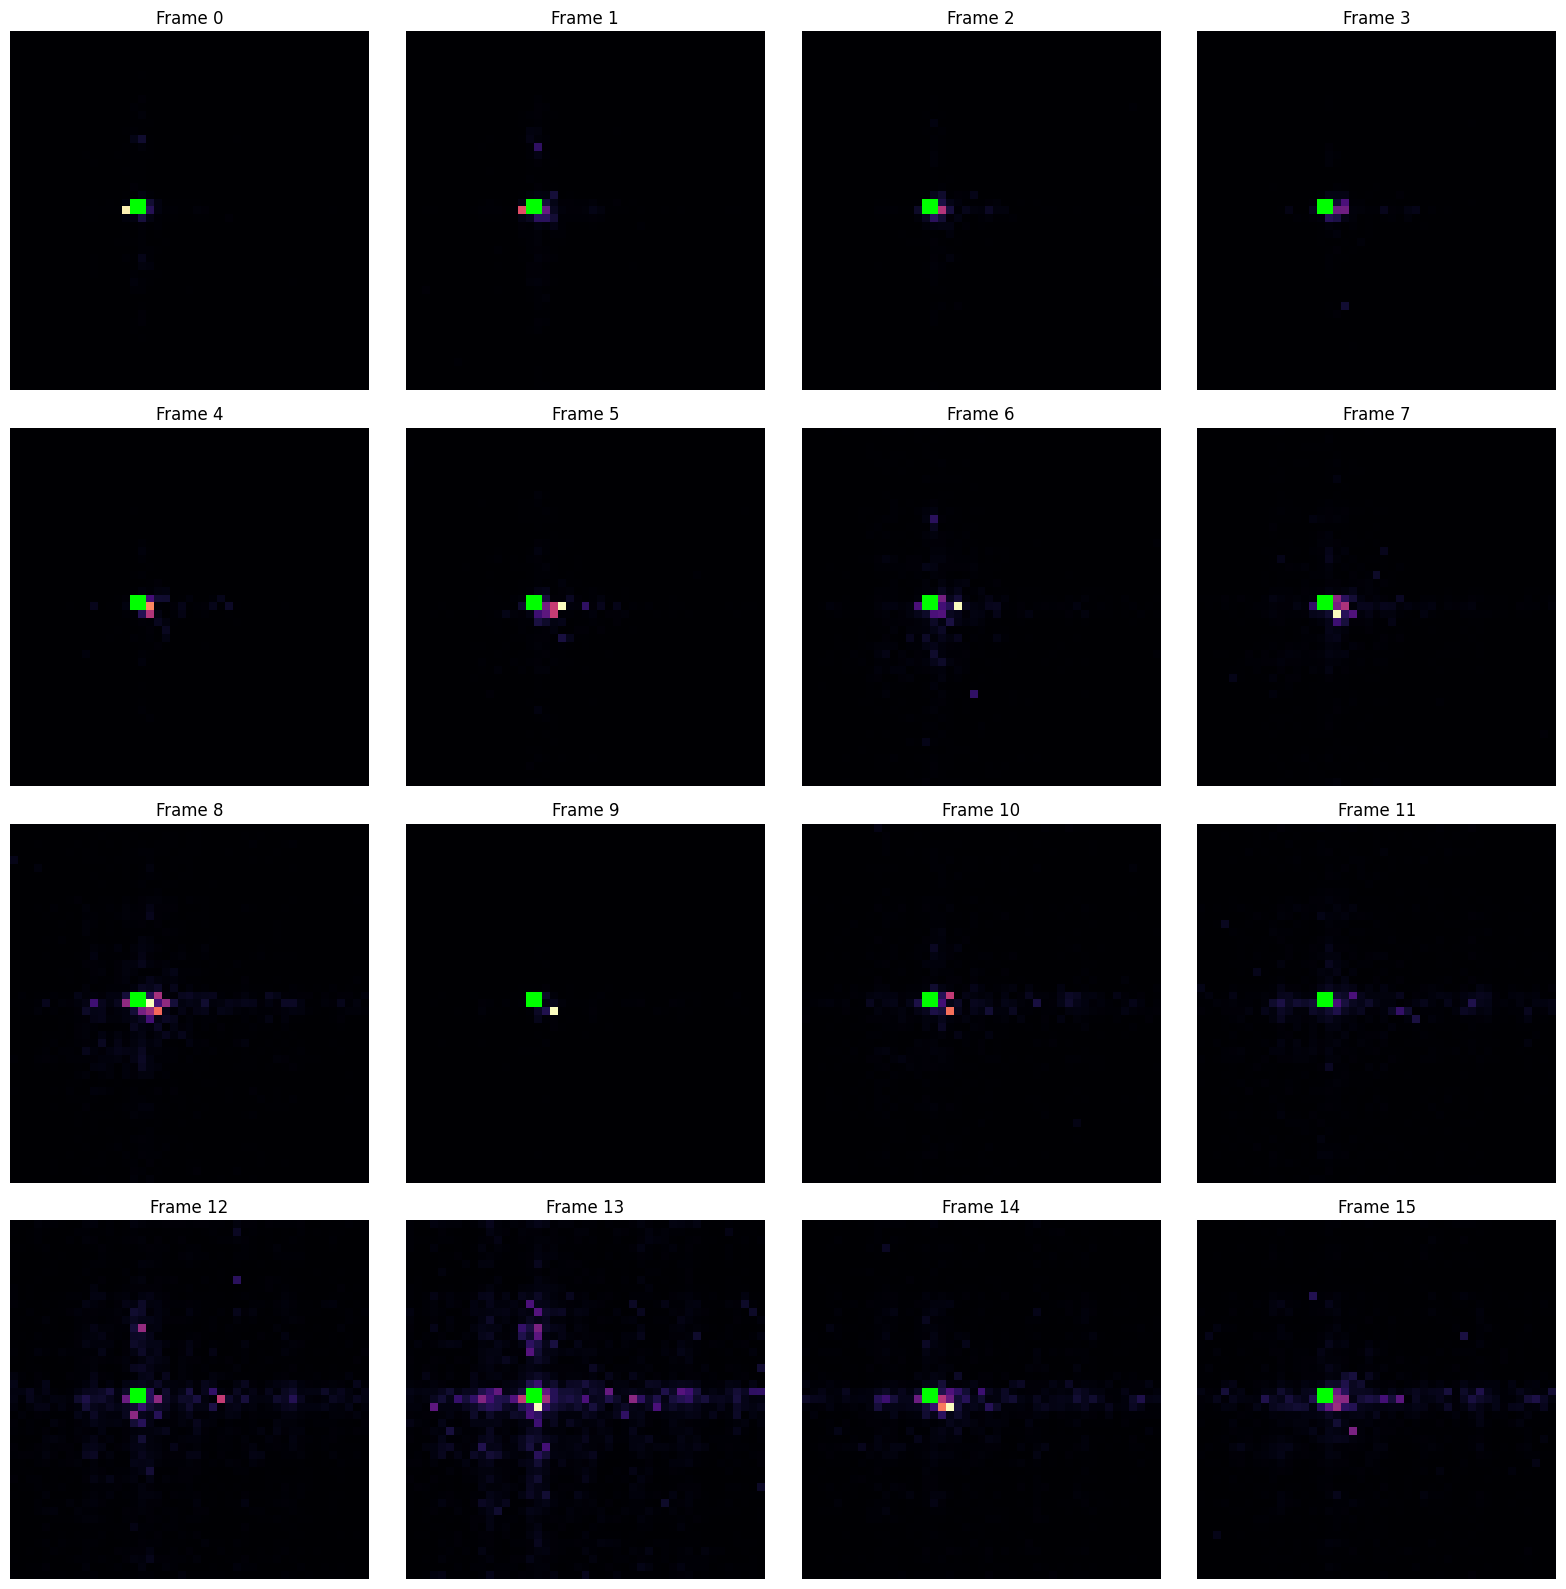

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Jupyter inline plotting
%matplotlib inline

############################################################
#                Hyperparameters 
############################################################
ATTN_MAP_PATH = "logs/attn_map_step2_layer38.pt"  # Attention map file (pt)
NUM_FRAMES = 16
HEIGHT = 45  
WIDTH = 45
TOKEN_IDX = 0*2025 + 22*45 + 16   # Example: t=0, h=22, w=16
############################################################

def load_and_reshape_attn_map(path, num_frames=16, height=45, width=45):
    """
    1. Load attention map from path (1D or 2D);
    2. Reshape to (32400,32400);
    3. Reshape to (16,45,45,16,45,45) for easier operations.
    """
    attn_map = torch.load(path)  # Assuming torch.Tensor
    expected_size = num_frames * height * width  # 16*45*45 = 32400
    
    attn_map = attn_map[:expected_size, :expected_size]  # => (32400, 32400)
    # reshape to (t, h, w, t, h, w)
    attn_map_6d = attn_map.reshape(num_frames, height, width, 
                                   num_frames, height, width)
    return attn_map_6d

def get_cross_attn_map(attn_map_6d: torch.Tensor, token_idx, 
                       num_frames=16, height=45, width=45):
    """
    Get single token or aggregated attention map from (t, h, w, t, h, w) => (t, h, w)
    """
    if isinstance(token_idx, list):
        mask = torch.zeros_like(attn_map_6d[0])  # => (t, h, w)
        for idx in token_idx:
            f_idx = idx // (height * width)
            hh = (idx % (height * width)) // width
            ww = idx % width
            mask += attn_map_6d[f_idx, hh, ww]
        mask /= len(token_idx)
    else:
        f_idx = token_idx // (height * width)
        hh = (token_idx % (height * width)) // width
        ww = token_idx % width
        mask = attn_map_6d[f_idx, hh, ww]
    return mask

def apply_magma_colormap(attn_2d: np.ndarray, mark_pos=None) -> np.ndarray:
    """
    Convert 2D attention map to RGB image with magma colormap (H x W x 3).
    Add green marker at specified position.
    """
    attn_2d = attn_2d - attn_2d.min()
    denom = (attn_2d.max() - attn_2d.min() + 1e-8)
    attn_2d = attn_2d / denom
    
    # Use matplotlib's magma colormap (returns RGBA)
    colored = plt.cm.magma(attn_2d)
    colored_rgb = (colored[..., :3] * 255).astype(np.uint8)
    
    # Add green marker at specified position
    if mark_pos is not None:
        h, w = mark_pos
        marker_size = 1
        colored_rgb[h-marker_size:h+marker_size, w-marker_size:w+marker_size] = [0, 255, 0]
        
    return colored_rgb

# =============== Load and get (t, h, w, t, h, w) cross-attention map ===============
if not os.path.exists(ATTN_MAP_PATH):
    raise FileNotFoundError(f"Attention map file not found: {ATTN_MAP_PATH}")

attn_map_6d = load_and_reshape_attn_map(ATTN_MAP_PATH, NUM_FRAMES, HEIGHT, WIDTH)
print("Reshaped attention map:", attn_map_6d.shape)

# =============== Get fixed token_idx => (t, h, w) ===============
attn_3d = get_cross_attn_map(attn_map_6d, TOKEN_IDX, NUM_FRAMES, HEIGHT, WIDTH)
print("attention_3d shape:", attn_3d.shape)

# =============== Show heatmap (frame by frame) ===============
num_frames = attn_3d.shape[0]
rows = 4
cols = num_frames // rows
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()  # flatten for easy indexing

for i in range(num_frames):
    attn_2d = attn_3d[i].cpu().numpy()
    # Add marker at position (22,16)
    color_map = apply_magma_colormap(attn_2d, mark_pos=(22,16))
    axes[i].imshow(color_map)
    axes[i].axis('off')
    axes[i].set_title(f"Frame {i}")

plt.tight_layout()
plt.show()

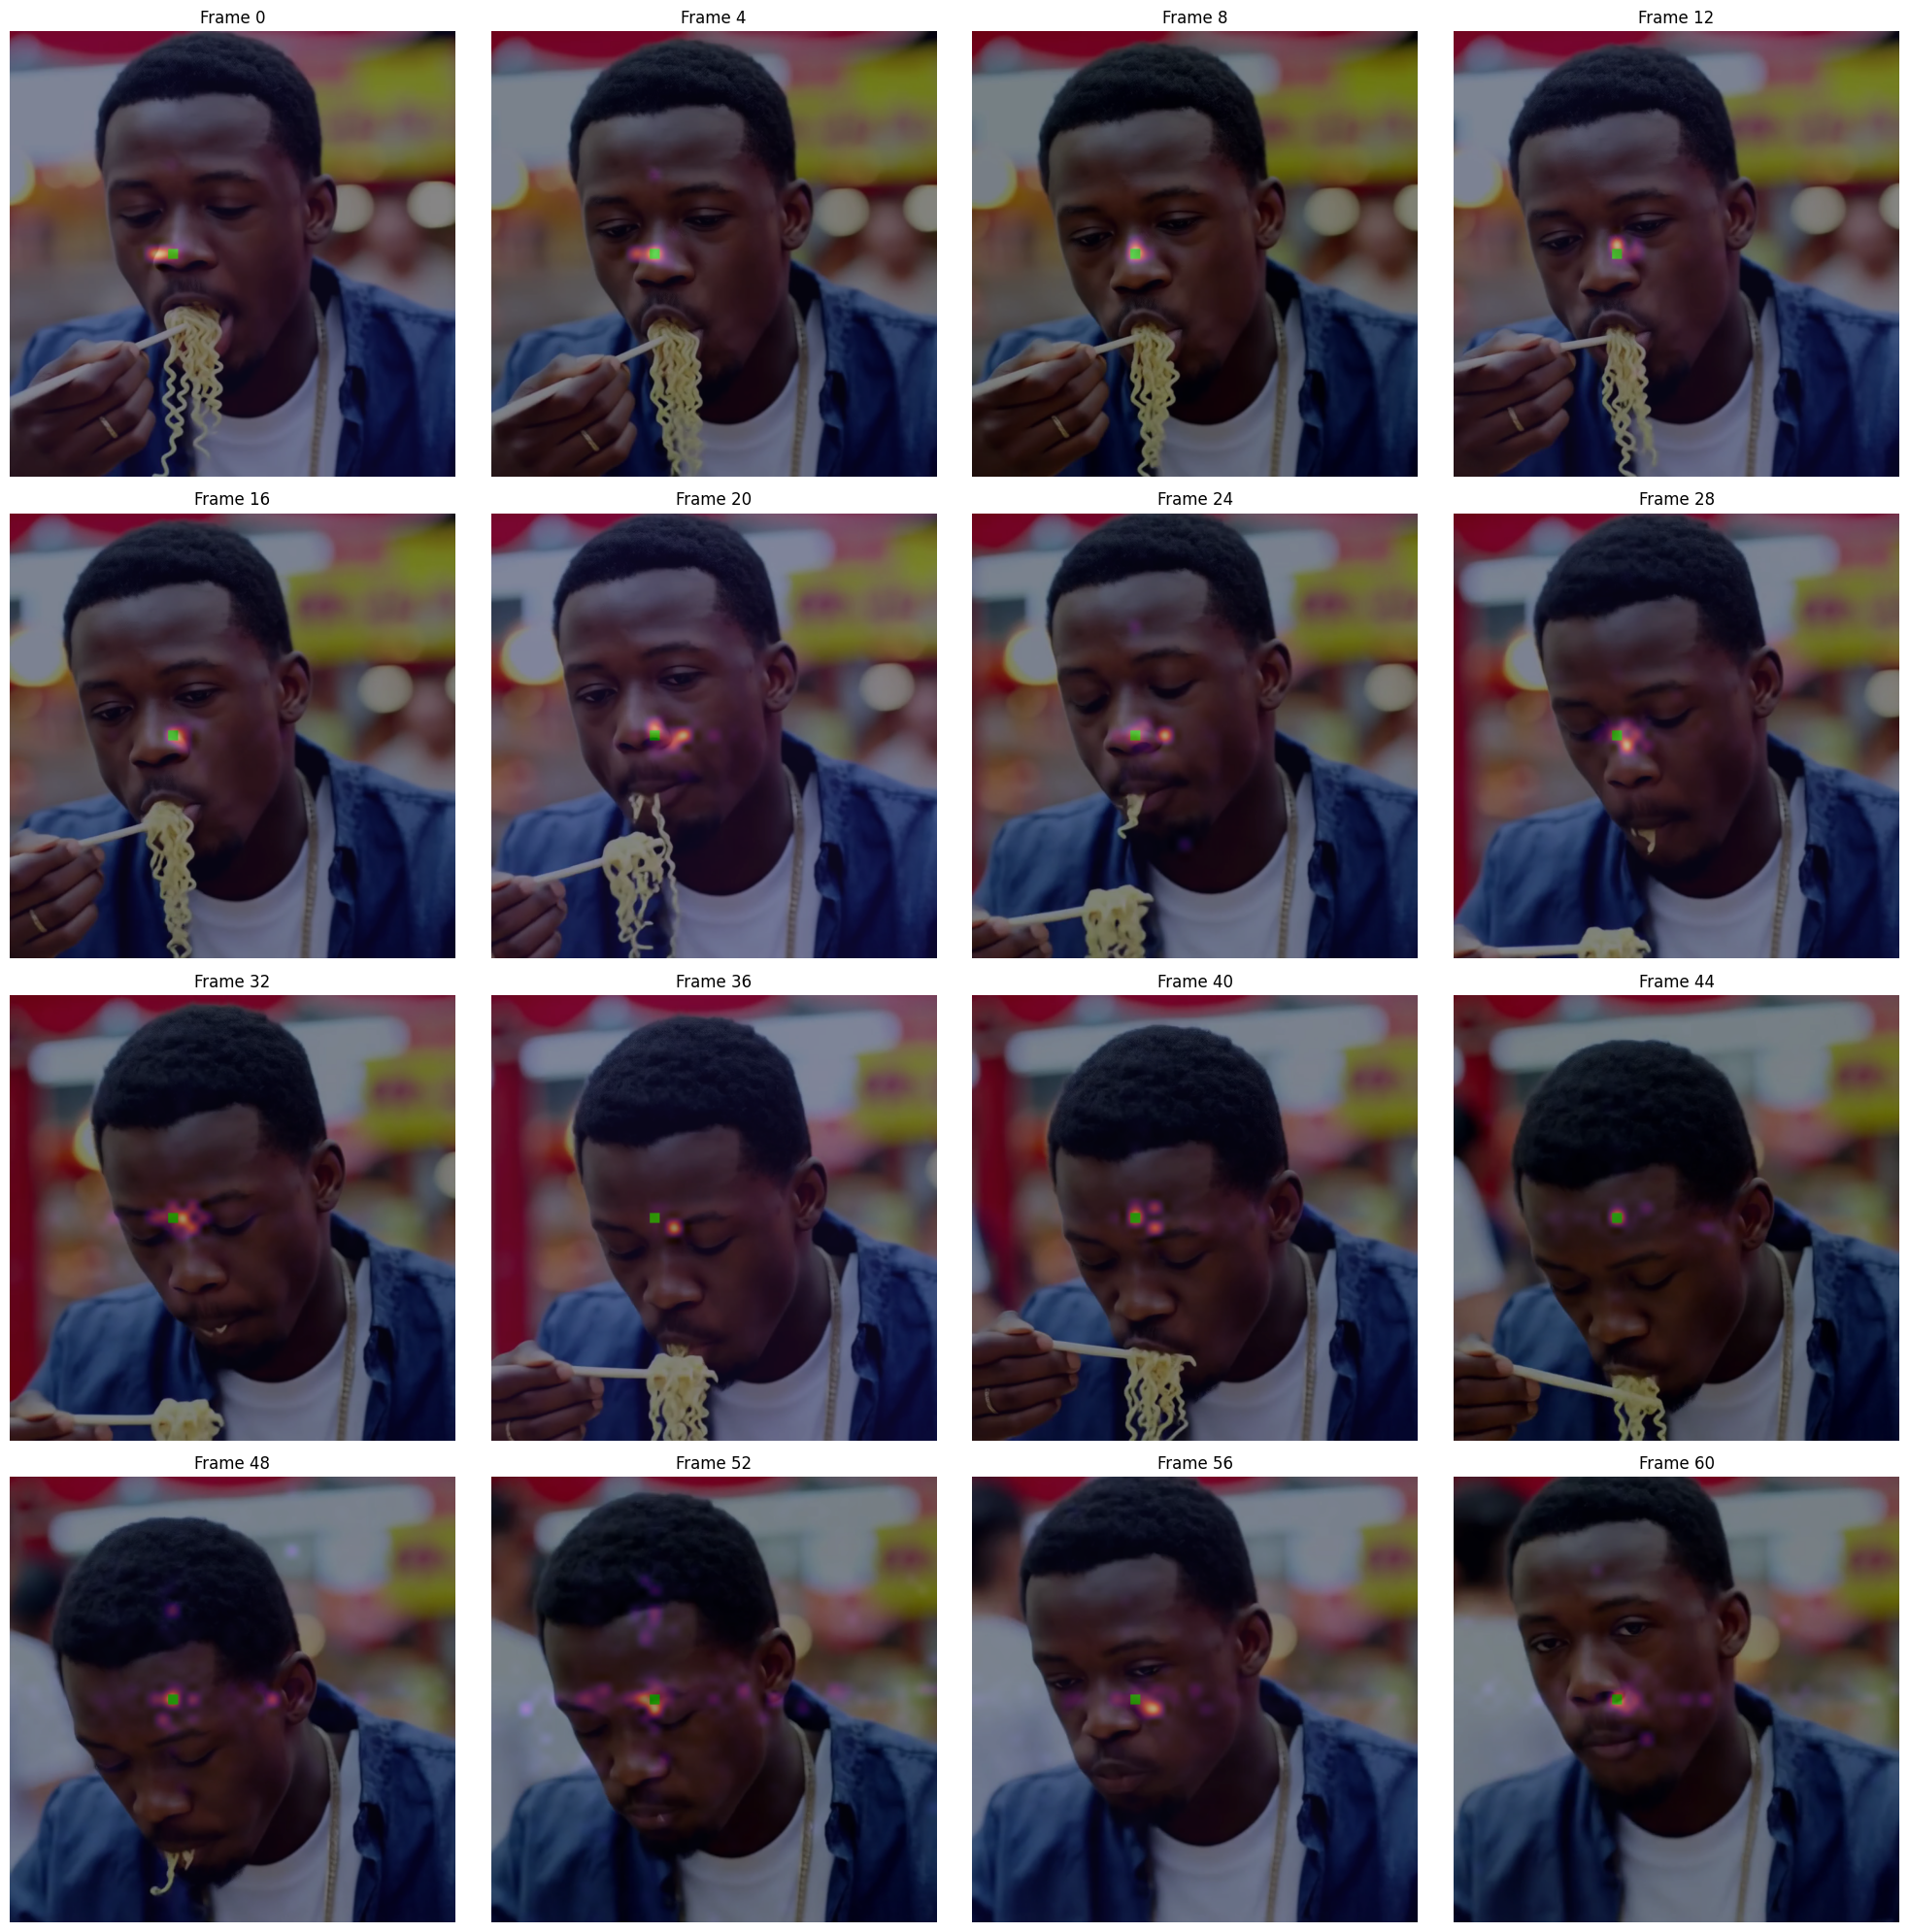

In [21]:
VIDEO_PATH = "outputs_video/hunyuan/sw/Will Smith casually eats noodles, his relaxed demeanor contrasting with the energetic background of .mp4"
NUM_FRAMES_TO_READ = 16
ALPHA = 0.5
HEIGHT, WIDTH = 720, 720
ATTN_T, ATTN_H, ATTN_W = 16, 45, 45
FRAME_INTERVAL = 4  # Add frame interval parameter

if not os.path.exists(VIDEO_PATH):
    raise FileNotFoundError(f"视频文件不存在: {VIDEO_PATH}")

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise IOError(f"无法打开视频: {VIDEO_PATH}")

frames = []
frame_count = 0

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
        
    if frame_count % FRAME_INTERVAL == 0:
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        frame_rgb = cv2.resize(frame_rgb, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
        frames.append(frame_rgb)
        
        if len(frames) >= NUM_FRAMES_TO_READ:
            break
            
    frame_count += 1

cap.release()

if len(frames) == 0:
    raise ValueError("未能成功读取任何视频帧。")
elif len(frames) < NUM_FRAMES_TO_READ:
    print(f"警告：只读取到 {len(frames)} 帧，少于预期的 {NUM_FRAMES_TO_READ} 帧")

# Rest of the visualization code remains the same
num_frames = len(frames)
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for i in range(rows * cols):
    if i < num_frames:
        frame_rgb = frames[i].copy()
        attn_2d = attn_3d[i].cpu().numpy()
        attn_2d_resized = cv2.resize(attn_2d, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
        
        # 标记原始坐标(22,16)对应在720x720图像上的位置
        h_scaled = int(22 * HEIGHT / ATTN_H)
        w_scaled = int(16 * WIDTH / ATTN_W)
        marker_size = 16
        
        heatmap_rgb = apply_magma_colormap(attn_2d_resized)
        # 在heatmap上添加绿色标记
        heatmap_rgb[h_scaled:h_scaled+marker_size, 
                    w_scaled:w_scaled+marker_size] = [0, 255, 0]
        
        blended = cv2.addWeighted(frame_rgb, 1 - ALPHA, heatmap_rgb, ALPHA, 0)
        axes[i].imshow(blended)
        axes[i].set_title(f"Frame {i*FRAME_INTERVAL}")
    else:
        axes[i].imshow(np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8))
        axes[i].set_title("Empty")

    axes[i].axis('off')

plt.tight_layout()
plt.show()